## Supervised Text Classification
---
**Author:** Katherine(Chuxin) Yang

I appreciate Rebecca(Jiayin) Zhao, Boon Xin Tan, and Shengdong Shi for labeling data, identifing keywords and tuning parameters in this research.


**Main Steps**
- [Load Data](#Load-Data)
- [Feature Engineering](#Feature-Engineering)
- [Deal with Missing Values](#Deal-with-Missing-Values)
- [Identify Dependent Variable](#Identify-Dependent-Variable)
- [Split Data](#Split-Data)
- [Class Balancing](#Class-Balancing)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Text Cleaning](#Text-Cleaning)
- [Latent Dirichlet Allocation (LDA)](#Latent-Dirichlet-Allocation-(LDA))
- [Neural Word Embedding (Word2Vec)](#Neural-Word-Embedding-(Word2Vec))
- [Preprocessing](#Preprocessing)
- [Model Fitting and Hyperparameter Tuning](#Model-Fitting-and-Hyperparameter-Tuning)
- [Evaluation](#Evaluation)
- [Error Analysis](#Error-Analysis)

In [1]:
!pip install statsmodels seaborn sklearn xgboost --quiet

In [2]:
!pip install rpy2

In [3]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

import seaborn as sns
import pandas as pd
import numpy as np
import math
import re

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

from gensim.corpora import Dictionary
from sklearn.preprocessing import LabelEncoder

from gensim.models.ldamulticore import LdaMulticore
from gensim.models.word2vec import Word2Vec
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
# hyperparameter training imports
from sklearn.model_selection import GridSearchCV

# visualization imports
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import base64
import io
%matplotlib inline
sns.set()

import matplotlib.pyplot as plt

from collections import Counter

from matplotlib import pyplot
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, roc_curve, plot_roc_curve, confusion_matrix, plot_confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB#, GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

import xgboost as xgb
from xgboost.sklearn import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Chuxin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Chuxin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Chuxin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Load Data

In [4]:
rawDat = pd.read_csv('GoFundMe_Data.csv', 
                  sep = ',',
                escapechar='\t')

rawDat

,id,launchdate,launchweek,launchmonth,zipcode,location,country,category,name,description,raised,goal,covid1,covid2,fundingratio,lngoal,lnraised,lnfundingratio,who
0,184313,07Apr2020,14,4,95134,"San Jose, CA",US,"Medical, Illness & Healing",helping out people in need help of face masks,i am trying to help everyone in need of face m...,20.0,5000.0,0,1,0.004000,8.517193,2.9957323,-5.298317,1
1,156667,28Mar2020,13,3,10065,"New York, NY",US,"Medical, Illness & Healing",urgent: help for hospital staff in nyc,"a week ago, a friend who works at an er in new...",7566.0,NaN,0,1,NaN,NaN,8.9314194,NaN,1
2,152479,26Mar2020,13,3,75063,"Irving, TX",US,Accidents & Emergencies,rebuild adore by kirsten,"dearest friends, family and hair besties...\n\...",2285.0,NaN,0,1,NaN,NaN,7.7341213,NaN,1
3,237350,24Apr2020,17,4,77984,"Shiner, TX",US,"Creative Arts, Music & Film",the emotions band benefit- live from shiner,to help our band members weather covid-19,1510.0,2500.0,0,1,0.604000,7.824046,7.3198647,-0.502527,1
4,160177,29Mar2020,13,3,28625,"Statesville, NC",US,"Medical, Illness & Healing",help ecuador to fight covid-19,ecuador is a small south-american country know...,795.0,25000.0,1,1,0.031800,10.126631,6.6783423,-3.417327,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1457,245715,27-Apr-20,17,4,33015,"Hialeah, FL",US,Accidents & Emergencies,please help us,i am a christ follower. i am a wife of a wonde...,1410.0,5000.0,0,1,0.282000,8.517193,7.2513452,-1.262308,0
1458,246872,27-Apr-20,17,4,90250,"Hawthorne, CA",US,Funerals & Memorials,blaza guadalupe gerald,my grandmother (abuelita) was tested positive ...,6922.0,5000.0,0,1,1.384400,8.517193,8.8424597,0.325989,0
1459,213440,17-Apr-20,16,4,14048,"Dunkirk, NY",US,Accidents & Emergencies,my family needs help,"hello my name is dana, i lost my job 3 years a...",200.0,500.0,0,1,0.400000,6.214608,5.2983174,-0.913794,0
1460,249609,28-Apr-20,17,4,28217,"Charlotte, NC",US,Animals & Pets,ralphie needs acl surgery,"my name is taylor simmons and my husband, sam,...",1601.0,2200.0,0,1,0.727727,7.696213,7.3783836,-0.316456,0


In [5]:
rawDat.dtypes

id                  int64
launchdate         object
launchweek          int64
launchmonth         int64
zipcode            object
location           object
country            object
category           object
name               object
description        object
raised            float64
goal              float64
covid1              int64
covid2              int64
fundingratio      float64
lngoal            float64
lnraised           object
lnfundingratio    float64
who                 int64
dtype: object

In [6]:
rawDat.describe()

,id,launchweek,launchmonth,raised,goal,covid1,covid2,fundingratio,lngoal,lnfundingratio,who
count,1462.000000,1462.000000,1462.000000,1461.000000,1.420000e+03,1462.000000,1462.0,1420.000000,1420.000000,1420.000000,1462.000000
mean,186370.741450,14.429549,3.673051,3792.165640,7.955347e+05,0.199042,1.0,0.746586,8.469491,-1.576577,0.587551
std,45111.220471,2.411790,0.626649,12913.454666,2.666756e+07,0.399417,0.0,8.794552,1.570251,1.665768,0.492444
min,5235.000000,1.000000,1.000000,0.000000,1.000000e+00,0.000000,1.0,0.000000,0.000000,-6.907755,0.000000
25%,150112.250000,13.000000,3.000000,330.000000,2.000000e+03,0.000000,1.0,0.085325,7.600903,-2.449676,0.000000
50%,185755.500000,15.000000,4.000000,1120.000000,5.000000e+03,0.000000,1.0,0.290000,8.517193,-1.234432,1.000000
75%,222102.000000,16.000000,4.000000,3132.000000,1.000000e+04,0.000000,1.0,0.715965,9.210341,-0.332729,1.000000
max,267286.000000,18.000000,5.000000,294072.000000,9.999990e+08,1.000000,1.0,330.000000,20.723265,5.799096,1.000000


## Feature Engineering

Extract state information from 'location' column

In [7]:
rawDat['location'] = rawDat['location'].str.strip()
rawDat['state'] = rawDat.location.str.extract(r'\b(\w+)$', expand=True)

In [8]:
mask = rawDat['state'].str.len() != 2
rawDat.loc[mask, 'state'] = 'unknown'

Concatenate 'name' column and 'description' column into 'text' column for better text mining

In [9]:
rawDat["text"] = rawDat["name"] + ' ' + rawDat["description"]

In [10]:
rawDat['text'].replace(np.nan, 'unknown', inplace= True)

Add domain lexicon features, based on manually identified keywords

For those campaigns for selves and immediate family members, we identified keywords such as my mother, my dad, my aunt, my uncle, my sister, my brother, my dog, my cat, my kid, my child, my story, my bill, my fee, my hope, my surgery, my heart, my cousin, puppy, grandparent, help me, help us, small business, out of work, support. I created a new column and labeld it '1' if the text contains that keyword.

In [11]:
mymy = rawDat['text'].str.contains('my mo|my dad|my aunt|my uncle|my sis|my brother|my dog|my cat|my kid|my child|my story|my bill|my fee|my hope|my surgery|my heart|my cousin')
rawDat.loc[mymy, 'have_my'] = 1

In [12]:
aaa = rawDat['text'].str.contains('pupp')
rawDat.loc[aaa, 'have_pupp'] = 1
zz = rawDat['text'].str.contains('grand')
rawDat.loc[zz, 'have_grand'] = 1
yy = rawDat['text'].str.contains('help me')
rawDat.loc[yy, 'have_helpme'] = 1
xx = rawDat['text'].str.contains('help us')
rawDat.loc[xx, 'have_helpus'] = 1
ww = rawDat['text'].str.contains('small business')
rawDat.loc[ww, 'have_small_business'] = 1
uu = rawDat['text'].str.contains('out of work')
rawDat.loc[uu, 'have_outofwork'] = 1
vv = rawDat['text'].str.contains('support')
rawDat.loc[vv, 'have_support'] = 1

For those campaigns for communities, organizations, institutes, healthcare professionals and other essential workers, we identified keywords such as their, 3d, non-profit, n95, staff, mask, ppe, community, frontline, meal, lunch, responder. I created a new column and labeld it '1' if the text contains that keyword.

In [13]:
rawDat["count_their"]= rawDat["text"].str.count('their')/rawDat['text'].str.len()

In [14]:
ccc = rawDat['text'].str.contains('3d')
rawDat.loc[ccc, 'have_3d'] = 1
ddd = rawDat['text'].str.contains('non-profit')
rawDat.loc[ddd, 'have_non_profit'] = 1
eee = rawDat['text'].str.contains('nonprofit')
rawDat.loc[eee, 'have_nonprofit'] = 1
bbbb = rawDat['text'].str.contains('n95')
rawDat.loc[bbbb, 'have_n95'] = 1
aa = rawDat['text'].str.contains('staff')
rawDat.loc[aa, 'have_staff'] = 1
bb = rawDat['text'].str.contains('mask')
rawDat.loc[bb, 'have_mask'] = 1
dd = rawDat['text'].str.contains(' ppe')
rawDat.loc[dd, 'have_ppe'] = 1
ee = rawDat['text'].str.contains('communit')
rawDat.loc[ee, 'have_communit'] = 1
ff = rawDat['text'].str.contains('frontline')
rawDat.loc[ff, 'have_frontline'] = 1
jj = rawDat['text'].str.contains('meal')
rawDat.loc[jj, 'have_meal'] = 1
kk = rawDat['text'].str.contains('lunch')
rawDat.loc[kk, 'have_lunch'] = 1
rr = rawDat['text'].str.contains('front line')
rawDat.loc[rr, 'have_front_line'] = 1
tt = rawDat['text'].str.contains('responder')
rawDat.loc[tt, 'have_responder'] = 1

In [15]:
rawDat

,id,launchdate,launchweek,launchmonth,zipcode,location,country,category,name,description,...,have_n95,have_staff,have_mask,have_ppe,have_communit,have_frontline,have_meal,have_lunch,have_front_line,have_responder
0,184313,07Apr2020,14,4,95134,"San Jose, CA",US,"Medical, Illness & Healing",helping out people in need help of face masks,i am trying to help everyone in need of face m...,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,156667,28Mar2020,13,3,10065,"New York, NY",US,"Medical, Illness & Healing",urgent: help for hospital staff in nyc,"a week ago, a friend who works at an er in new...",...,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2,152479,26Mar2020,13,3,75063,"Irving, TX",US,Accidents & Emergencies,rebuild adore by kirsten,"dearest friends, family and hair besties...\n\...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,237350,24Apr2020,17,4,77984,"Shiner, TX",US,"Creative Arts, Music & Film",the emotions band benefit- live from shiner,to help our band members weather covid-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,160177,29Mar2020,13,3,28625,"Statesville, NC",US,"Medical, Illness & Healing",help ecuador to fight covid-19,ecuador is a small south-american country know...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1457,245715,27-Apr-20,17,4,33015,"Hialeah, FL",US,Accidents & Emergencies,please help us,i am a christ follower. i am a wife of a wonde...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1458,246872,27-Apr-20,17,4,90250,"Hawthorne, CA",US,Funerals & Memorials,blaza guadalupe gerald,my grandmother (abuelita) was tested positive ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1459,213440,17-Apr-20,16,4,14048,"Dunkirk, NY",US,Accidents & Emergencies,my family needs help,"hello my name is dana, i lost my job 3 years a...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1460,249609,28-Apr-20,17,4,28217,"Charlotte, NC",US,Animals & Pets,ralphie needs acl surgery,"my name is taylor simmons and my husband, sam,...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Deal with Missing Values

In [16]:
round(rawDat.isna().sum()/len(rawDat), 3)

id                     0.000
launchdate             0.000
launchweek             0.000
launchmonth            0.000
zipcode                0.000
location               0.005
country                0.000
category               0.020
name                   0.000
description            0.000
raised                 0.001
goal                   0.029
covid1                 0.000
covid2                 0.000
fundingratio           0.029
lngoal                 0.029
lnraised               0.004
lnfundingratio         0.029
who                    0.000
state                  0.000
text                   0.000
have_my                0.791
have_pupp              0.951
have_grand             0.915
have_helpme            0.860
have_helpus            0.836
have_small_business    0.910
have_outofwork         0.941
have_support           0.553
count_their            0.000
have_3d                0.985
have_non_profit        0.975
have_nonprofit         0.984
have_n95               0.981
have_staff    

Clearly we do have a fair amount of missing data. As noted above, some models such as decision trees can handle missing data just fine. Others such as support vector machines (SVM) cannot. So I did some preprocessing of the data to:

1. impute missing numeric data using column medians, such as 'raised', 'goal' columns
2. impute missing categorical data using a constant label 'unknown', such as 'category', 'location' columns
3. impute missing data with '0' for those columns that we just created for the keywords.

In [17]:
raised_array = rawDat[rawDat["raised"]!=np.nan]["raised"]
rawDat["raised"].replace(np.nan, raised_array.median(), inplace = True)

In [18]:
goal_array = rawDat[rawDat["goal"]!=np.nan]["goal"]
rawDat["goal"].replace(np.nan, goal_array.median(), inplace = True)

In [19]:
rawDat['category'].replace(np.nan, 'unknown', inplace= True)
rawDat['location'].replace(np.nan, 'unknown', inplace= True)

In [20]:
rawDat['have_my'].replace(np.nan, 0, inplace= True)
rawDat['have_pupp'].replace(np.nan, 0, inplace= True)
rawDat['have_grand'].replace(np.nan, 0, inplace= True)
rawDat['have_helpme'].replace(np.nan, 0, inplace= True)
rawDat['have_helpus'].replace(np.nan, 0, inplace= True)
rawDat['have_support'].replace(np.nan, 0, inplace= True)
rawDat['have_small_business'].replace(np.nan, 0, inplace= True)
rawDat['have_outofwork'].replace(np.nan, 0, inplace= True)

rawDat['have_3d'].replace(np.nan, 0, inplace= True)
rawDat['have_non_profit'].replace(np.nan, 0, inplace= True)
rawDat['have_nonprofit'].replace(np.nan, 0, inplace= True)
rawDat['have_n95'].replace(np.nan, 0, inplace= True)
rawDat['have_staff'].replace(np.nan, 0, inplace= True)
rawDat['have_mask'].replace(np.nan, 0, inplace= True)
rawDat['have_ppe'].replace(np.nan, 0, inplace= True)
rawDat['have_communit'].replace(np.nan, 0, inplace= True) 
rawDat['have_frontline'].replace(np.nan, 0, inplace= True)
rawDat['have_meal'].replace(np.nan, 0, inplace= True)
rawDat['have_lunch'].replace(np.nan, 0, inplace= True)
rawDat['have_front_line'].replace(np.nan, 0, inplace= True)
rawDat['have_responder'].replace(np.nan, 0, inplace= True)

## Identify Dependent Variable

In [21]:
rawDat.who.replace([0, 1], ['self', 'community'], inplace=True)

In [22]:
rawDat.groupby('who').size()

who
community    859
self         603
dtype: int64

There's a class balance skewed in favor of community. Let's look at the visualizations.

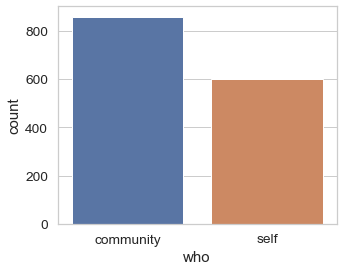

In [23]:
sns.set(rc = {'figure.figsize': (5, 4)},
        font_scale = 1.25) # increase text size on plots (e.g., axis labels)
sns.set_style('whitegrid')

sns.countplot(x = 'who', 
              data = rawDat)

## Split Data

I separated the labeled datasets into a training (80%) and test (20%) set. The test set is used to report the final model performance.

In [24]:
Train, Test = train_test_split(rawDat, 
                               stratify = rawDat.who,
                               test_size = 0.20, 
                               random_state = 345)

## Class Balancing

In [25]:
display(Train.groupby('who').size())
round(Train.groupby('who').size()/len(Train), 3)

who
community    687
self         482
dtype: int64

who
community    0.588
self         0.412
dtype: float64

While looking at our DV, there's a clear class imbalance in the data. To reduce the modeling bias, I downsampled the majority class of the training data.

In [26]:
np.random.seed(345) # to create reproducible results

maj_class = np.where(Train.who == 'community')[0]
min_class = np.where(Train.who == 'self')[0]

resample = np.random.choice(maj_class, size = len(min_class), replace = False)

TrainDS = pd.concat([Train.iloc[min_class], Train.iloc[resample]])

TrainDS.shape

(964, 43)

## Exploratory Data Analysis

We had a look at a couple of things, such as how many documents we had per label and the lengths of the documents

In [27]:
TrainDS.sample()

,id,launchdate,launchweek,launchmonth,zipcode,location,country,category,name,description,...,have_n95,have_staff,have_mask,have_ppe,have_communit,have_frontline,have_meal,have_lunch,have_front_line,have_responder
1161,143165,23Mar2020,12,3,94111,"San Francisco, CA",US,unknown,tadich grill - covid-19 employee relief fund,dear friends of tadich grill ??????\n\nso many...,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [28]:
doc_lengths = np.array(list(map(len, TrainDS.text.str.split(' '))))

print("The average number of words in a document is: {}.".format(round(np.mean(doc_lengths))))
print("The minimum number of words in a document is: {}.".format(min(doc_lengths)))
print("The maximum number of words in a document is: {}.".format(max(doc_lengths)))

The average number of words in a document is: 294.0.
The minimum number of words in a document is: 18.
The maximum number of words in a document is: 1694.


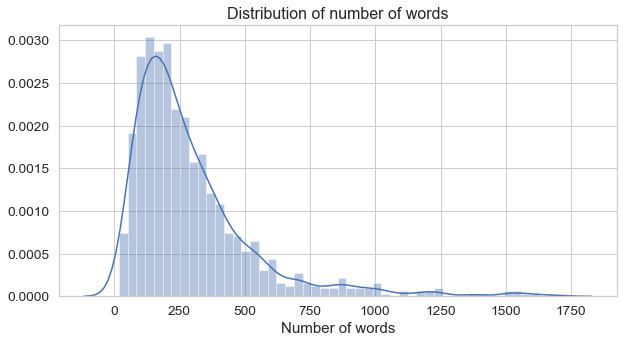

In [29]:
fig,ax =plt.subplots(figsize=(10,5))
ax.set_title("Distribution of number of words", fontsize=16)
ax.set_xlabel("Number of words")
sns.distplot(doc_lengths, bins=50, ax=ax);

For LDA and Word2Vec techniques, I consulted an open-source Kaggle notebook and applied some code into my script. Here is the [Reference](https://www.kaggle.com/vukglisovic/classification-combining-lda-and-word2vec). 

## Text Cleaning

Remove punctuations and numbers

In [30]:
def get_good_tokens(sentence):
    replaced_punctation1 = list(map(lambda token: re.sub('[^0-9A-Za-z!?]+', '', token), sentence))
    replaced_punctation2 = list(map(lambda token: re.sub(r'[?|!|\'|"|#]', '', token), replaced_punctation1))
    removed_punctation = list(filter(lambda token: token, replaced_punctation2))
    return removed_punctation

Split into sentences and tokenize sentences in words

In [31]:
def w2v_preprocessing(df):
    
    df['text'] = df.text.str.lower()
    df['document_sentences'] = df.text.str.split('.')  # split texts into individual sentences
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(map(nltk.word_tokenize, sentences)),
                                         df.document_sentences))  # tokenize sentences
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(map(get_good_tokens, sentences)),
                                         df.tokenized_sentences))  # remove unwanted characters
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(filter(lambda lst: lst, sentences)),
                                         df.tokenized_sentences))  # remove empty lists

w2v_preprocessing(TrainDS)

In [32]:
def lda_get_good_tokens(df):
    df['text'] = df.text.str.lower()
    df['tokenized_text'] = list(map(nltk.word_tokenize, df.text))
    df['tokenized_text'] = list(map(get_good_tokens, df.tokenized_text))

lda_get_good_tokens(TrainDS)

We had a look at the top word frequencies now to get an idea of the words that are used mostly.

In [33]:
tokenized_only_dict = Counter(np.concatenate(TrainDS.tokenized_text.values))

tokenized_only_df = pd.DataFrame.from_dict(tokenized_only_dict, orient='index')
tokenized_only_df.rename(columns={0: 'count'}, inplace=True)

In [34]:
tokenized_only_df.sort_values('count', ascending=False, inplace=True)

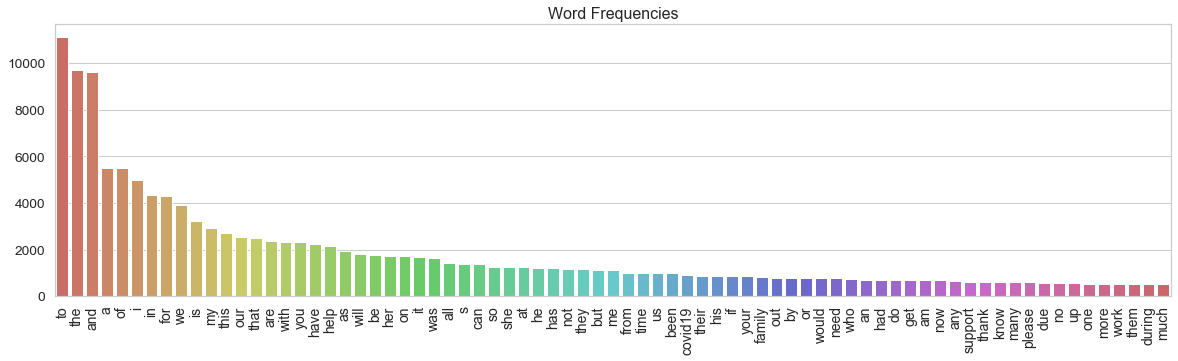

In [35]:
def word_frequency_barplot(df, nr_top_words=75):
    """ df should have a column named count.
    """
    fig, ax = plt.subplots(1,1,figsize=(20,5))

    sns.barplot(list(range(nr_top_words)), df['count'].values[:nr_top_words], palette='hls', ax=ax)

    ax.set_xticks(list(range(nr_top_words)))
    ax.set_xticklabels(df.index[:nr_top_words], fontsize=14, rotation=90)
    return ax
    
ax = word_frequency_barplot(tokenized_only_df)
ax.set_title("Word Frequencies", fontsize=16);

Remove stopwords

In [36]:
def remove_stopwords(df):
    """ Removes stopwords based on a known set of stopwords
    available in the nltk package. In addition, we include our
    made up word in here.
    """
    # Luckily nltk already has a set of stopwords that we can remove from the texts.
    stopwords = nltk.corpus.stopwords.words('english')
    # we'll add our own special word in here 'qwerty'
    #stopwords.append(our_special_word)

    df['stopwords_removed'] = list(map(lambda doc:
                                       [word for word in doc if word not in stopwords],
                                       df['tokenized_text']))

remove_stopwords(TrainDS)

Stemming

In [37]:
def stem_words(df):
    lemm = nltk.stem.WordNetLemmatizer()
    df['lemmatized_text'] = list(map(lambda sentence:
                                     list(map(lemm.lemmatize, sentence)),
                                     df.stopwords_removed))

    p_stemmer = nltk.stem.porter.PorterStemmer()
    df['stemmed_text'] = list(map(lambda sentence:
                                  list(map(p_stemmer.stem, sentence)),
                                  df.lemmatized_text))

stem_words(TrainDS)

Vectorize Words

Since a computer can't reallly understand what a word means, we need to transform it into some number the model will be able to work with. We used gensim.corpora.Dictionary for this. 

In [38]:
dictionary = Dictionary(documents=TrainDS.stemmed_text.values) 

print("Found {} words.".format(len(dictionary.values())))

Found 12006 words.


In [39]:
dictionary.filter_extremes(no_above=0.9, no_below=2) # I removed the top 10% of words and words that occur less than 2 times.
dictionary.compactify()  # Reindexes the remaining words after filtering
print("Left with {} words.".format(len(dictionary.values())))

Left with 5325 words.


In [40]:
def document_to_bow(df):
    df['bow'] = list(map(lambda doc: dictionary.doc2bow(doc), df.stemmed_text))
    
document_to_bow(TrainDS)

In [41]:
def lda_preprocessing(df):
    """ All the preprocessing steps for LDA are combined in this function.
    All mutations are done on the dataframe itself. So this function returns
    nothing.
    """
    lda_get_good_tokens(df)
    remove_stopwords(df)
    stem_words(df)
    document_to_bow(df)

Visualize the cleansed words frequency

In [42]:
cleansed_words_df = pd.DataFrame.from_dict(dictionary.token2id, orient='index')
cleansed_words_df.rename(columns={0: 'id'}, inplace=True)

cleansed_words_df['count'] = list(map(lambda id_: dictionary.dfs.get(id_), cleansed_words_df.id))
del cleansed_words_df['id']

In [43]:
cleansed_words_df.sort_values('count', ascending=False, inplace=True)

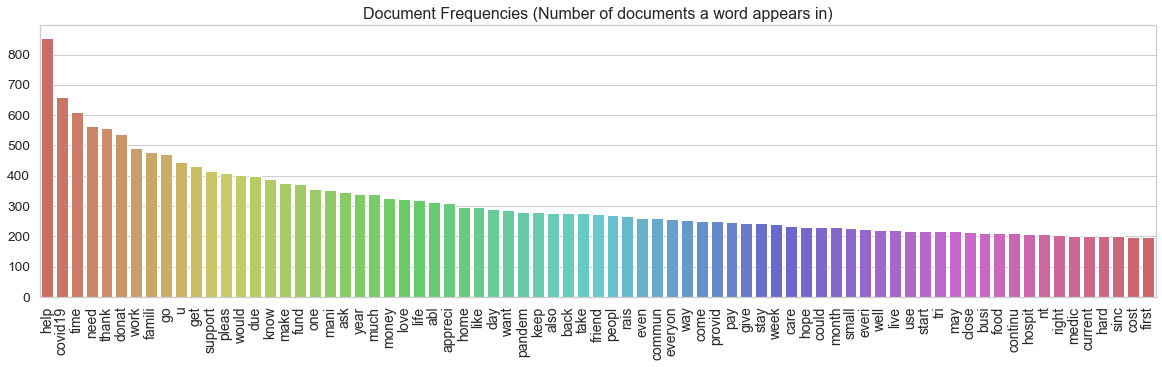

In [44]:
ax = word_frequency_barplot(cleansed_words_df)
ax.set_title("Document Frequencies (Number of documents a word appears in)", fontsize=16);

Visualize how often words were used for different labels.

In [45]:
self_words = list(np.concatenate(TrainDS.loc[TrainDS.who == 'self', 'stemmed_text'].values))
community_words = list(np.concatenate(TrainDS.loc[TrainDS.who == 'community', 'stemmed_text'].values))

In [46]:
self_word_frequencies = {word: self_words.count(word) for word in cleansed_words_df.index[:50]}
community_word_frequencies = {word: community_words.count(word) for word in cleansed_words_df.index[:50]}

In [47]:
frequencies_df = pd.DataFrame(index=cleansed_words_df.index[:50])

In [48]:
frequencies_df['self_freq'] = list(map(lambda word:
                                      self_word_frequencies[word],
                                      frequencies_df.index))
frequencies_df['self_community_freq'] = list(map(lambda word:
                                          self_word_frequencies[word] + community_word_frequencies[word],
                                          frequencies_df.index))

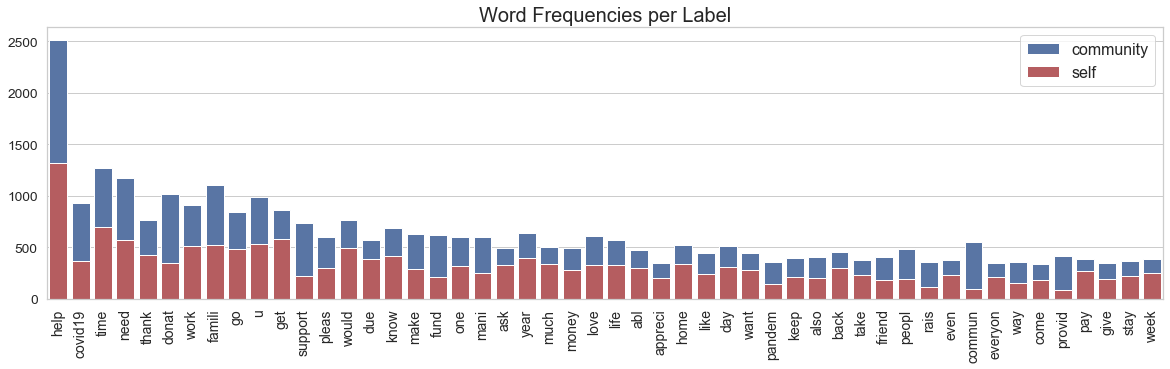

In [49]:
fig, ax = plt.subplots(1,1,figsize=(20,5))

nr_top_words = len(frequencies_df)
nrs = list(range(nr_top_words))
sns.barplot(nrs, frequencies_df['self_community_freq'].values, color='b', ax=ax, label="community")
sns.barplot(nrs, frequencies_df['self_freq'].values, color='r', ax=ax, label="self")

ax.set_title("Word Frequencies per Label", fontsize=20)
ax.legend(prop={'size': 16})
ax.set_xticks(nrs)
ax.set_xticklabels(frequencies_df.index, fontsize=14, rotation=90);

## Latent Dirichlet Allocation (LDA)

In [50]:
corpus = TrainDS.bow

In [51]:
%%time
num_topics = 15 # Map campaign texts to 15 LDA-extrated topics
#A multicore approach to decrease training time
LDAmodel = LdaMulticore(corpus=corpus,
                        id2word=dictionary,
                        num_topics=num_topics,
                        workers=4,
                        chunksize=4000,
                        passes=7,
                        alpha='asymmetric')

Wall time: 20.2 s


In [52]:
def document_to_lda_features(lda_model, document):
    """ Transforms a bag of words document to features.
    It returns the proportion of how much each topic was
    present in the document.
    """
    topic_importances = LDAmodel.get_document_topics(document, minimum_probability=0)
    topic_importances = np.array(topic_importances)
    return topic_importances[:,1]

TrainDS['lda_features'] = list(map(lambda doc:
                                      document_to_lda_features(LDAmodel, doc),
                                      TrainDS.bow))

In [53]:
self_topic_distribution = TrainDS.loc[TrainDS.who == 'self', 'lda_features'].mean()
community_topic_distribution = TrainDS.loc[TrainDS.who == 'community', 'lda_features'].mean()

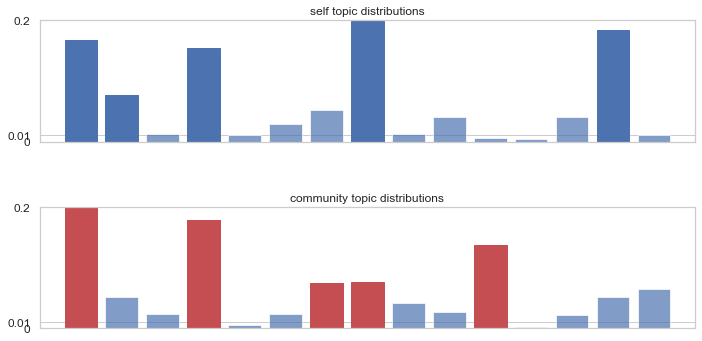

In [54]:
fig, [ax1,ax2] = plt.subplots(2,1,figsize=(10,5))

nr_top_bars = 5

ax1.set_title("self topic distributions", fontsize=12)
ax2.set_title("community topic distributions", fontsize=12)
#ax3.text(-10, 0.04, "Average Probability of Topic", fontsize=30, ha="center", va="center",
#         rotation="vertical")

for ax, distribution, color in zip([ax1,ax2],
                                   [self_topic_distribution,community_topic_distribution],
                                   ['b', 'r']):
    # Individual distribution barplots
    ax.bar(range(len(distribution)), distribution, alpha=0.7)
    rects = ax.patches
    for i in np.argsort(distribution)[-nr_top_bars:]:
        rects[i].set_color(color)
        rects[i].set_alpha(1)
    # General plotting adjustments
    ax.set_xlim(-1, 15)
    ax.set_xticks(range(20,14,20))
    ax.set_xticklabels(range(20,14,20), fontsize=12)
    ax.set_ylim(0,0.2)
    ax.set_yticks([0,0.01,0.2])
    ax.set_yticklabels([0,0.01,0.2], fontsize=12)

fig.tight_layout(h_pad=3.)

In [55]:
def get_topic_top_words(lda_model, topic_id, nr_top_words=10):
    """ Returns the top words for topic_id from lda_model.
    """
    id_tuples = lda_model.get_topic_terms(topic_id, topn=nr_top_words)
    word_ids = np.array(id_tuples)[:,0]
    words = map(lambda id_: lda_model.id2word[id_], word_ids)
    return words

In [56]:
for who, distribution in zip(['self', 'community'], [self_topic_distribution, community_topic_distribution]):
    print("Looking up top words from top topics from {}.".format(who))
    for x in sorted(np.argsort(distribution)[-5:]):
        top_words = get_topic_top_words(LDAmodel, x)
        print("For topic {}, the top words are: {}.".format(x, ", ".join(top_words)))
    print("")

Looking up top words from top topics from self.
For topic 0, the top words are: help, busi, support, donat, time, covid19, fund, u, small, need.
For topic 1, the top words are: help, need, mask, hospit, get, medic, doctor, would, test, make.
For topic 3, the top words are: famili, help, time, donat, need, go, u, love, pleas, work.
For topic 7, the top words are: help, time, get, know, nt, go, would, u, work, need.
For topic 13, the top words are: help, need, get, time, work, go, home, u, dog, thank.

Looking up top words from top topics from community.
For topic 0, the top words are: help, busi, support, donat, time, covid19, fund, u, small, need.
For topic 3, the top words are: famili, help, time, donat, need, go, u, love, pleas, work.
For topic 6, the top words are: help, time, u, work, would, famili, home, child, need, school.
For topic 7, the top words are: help, time, get, know, nt, go, would, u, work, need.
For topic 10, the top words are: need, mask, covid19, donat, help, commun

## Neural Word Embedding (Word2Vec)

In [57]:
sentences = []
for sentence_group in TrainDS.tokenized_sentences:
    sentences.extend(sentence_group)

print("Number of sentences: {}.".format(len(sentences)))
print("Number of texts: {}.".format(len(TrainDS)))

Number of sentences: 14983.
Number of texts: 964.


In [58]:
%%time
# Set values for various parameters
num_features = 85    # Word vector dimensionality
min_word_count = 2    # Minimum word count
num_workers = 5       # Number of threads to run in parallel
context = 6           # Context window size
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model
W2Vmodel = Word2Vec(sentences=sentences,
                    sg=1,
                    hs=0,
                    workers=num_workers,
                    size=num_features,
                    min_count=min_word_count,
                    window=context,
                    sample=downsampling,
                    negative=5,
                    iter=10)

Wall time: 9.41 s


Word2Vec Visualization

In [59]:
def get_w2v_features(w2v_model, sentence_group):
    """ Transform a sentence_group (containing multiple lists
    of words) into a feature vector. It averages out all the
    word vectors of the sentence_group.
    """
    words = np.concatenate(sentence_group)  # words in text
    index2word_set = set(w2v_model.wv.vocab.keys())  # words known to model
    
    featureVec = np.zeros(w2v_model.vector_size, dtype="float32")
    
    # Initialize a counter for number of words in a review
    nwords = 0
    # Loop over each word in the comment and, if it is in the model's vocabulary, add its feature vector to the total
    for word in words:
        if word in index2word_set: 
            featureVec = np.add(featureVec, w2v_model[word])
            nwords += 1.

    # Divide the result by the number of words to get the average
    if nwords > 0:
        featureVec = np.divide(featureVec, nwords)
    return featureVec

TrainDS['w2v_features'] = list(map(lambda sen_group:
                                      get_w2v_features(W2Vmodel, sen_group),
                                      TrainDS.tokenized_sentences))

In [60]:
self_w2v_distribution = TrainDS.loc[TrainDS.who == 'self', 'w2v_features'].mean()
community_w2v_distribution = TrainDS.loc[TrainDS.who == 'community', 'w2v_features'].mean()

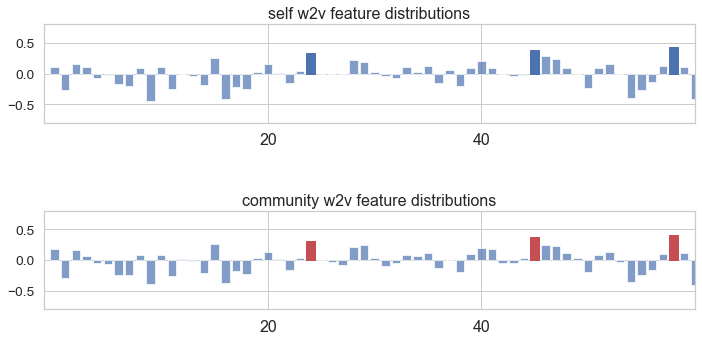

In [61]:
fig, [ax1,ax2] = plt.subplots(2,1,figsize=(10, 5))

nr_top_bars = 5

ax1.set_title("self w2v feature distributions", fontsize=16)
ax2.set_title("community w2v feature distributions", fontsize=16)
# ax3.text(-10, 2.3, "Average feature vectors", fontsize=30, ha="center", va="center", rotation="vertical")

for ax, distribution, color in zip([ax1,ax2], [self_w2v_distribution,community_w2v_distribution], ['b', 'r']):
    # Individual distribution barplots
    ax.bar(range(len(distribution)), distribution, alpha=0.7)
    rects = ax.patches
    for i in np.argsort(distribution)[-nr_top_bars:]:
        rects[i].set_color(color)
        rects[i].set_alpha(1)
    # General plotting adjustments
    ax.set_xlim(-1, 60)
    ax.set_xticks(range(20,59,20))
    ax.set_xticklabels(range(20,59,20), fontsize=16)
    ax.set_ylim(-0.8,0.8)

fig.tight_layout(h_pad=3.)

In [62]:
TrainDS

,id,launchdate,launchweek,launchmonth,zipcode,location,country,category,name,description,...,have_responder,document_sentences,tokenized_sentences,tokenized_text,stopwords_removed,lemmatized_text,stemmed_text,bow,lda_features,w2v_features
866,216446,18Apr2020,16,4,95307,"Ceres, CA",US,Other,"lied to, manipulated and abused by my own mother.","this is jhaala coleman, my wonderful, kind-hea...",...,0.0,"[lied to, manipulated and abused by my own mot...","[[lied, to, manipulated, and, abused, by, my, ...","[lied, to, manipulated, and, abused, by, my, o...","[lied, manipulated, abused, mother, jhaala, co...","[lied, manipulated, abused, mother, jhaala, co...","[lie, manipul, abus, mother, jhaala, coleman, ...","[(0, 1), (1, 1), (2, 1), (3, 3), (4, 1), (5, 1...","[0.0006597306928597391, 0.11469285190105438, 0...","[0.09261941, -0.25412557, 0.17528823, 0.111201..."
622,205974,15Apr2020,16,4,33756,"Clearwater, FL",US,Other,"covidmove:need a new apt.by end of may, lease ...",joining the rest of the world in need of some ...,...,0.0,"[covidmove:need a new apt, by end of may, leas...","[[covidmove, need, a, new, apt], [by, end, of,...","[covidmove, need, a, new, aptby, end, of, may,...","[covidmove, need, new, aptby, end, may, lease,...","[covidmove, need, new, aptby, end, may, lease,...","[covidmov, need, new, aptbi, end, may, leas, e...","[(39, 3), (55, 2), (66, 2), (68, 1), (78, 1), ...","[0.040574900805950165, 0.001306013436987996, 0...","[0.15127999, -0.23404865, 0.17008887, 0.096775..."
234,226549,21Apr2020,16,4,10033,"New York, NY",US,Education & Learning,college tuition fall 2020,"hello, my name is lizbeth falcon and i????????...",...,0.0,"[college tuition fall 2020 hello, my name is l...","[[college, tuition, fall, 2020, hello, my, nam...","[college, tuition, fall, 2020, hello, my, name...","[college, tuition, fall, 2020, hello, name, li...","[college, tuition, fall, 2020, hello, name, li...","[colleg, tuition, fall, 2020, hello, name, liz...","[(10, 1), (19, 1), (22, 1), (26, 3), (41, 1), ...","[0.5136613845825195, 0.0019601997919380665, 0....","[0.029511055, -0.2478422, 0.13746922, 0.071191..."
773,138953,22Mar2020,12,3,49508,"Grand Rapids, MI",US,Accidents & Emergencies,chad and johana kauffman,"dear friends. on march 18, my brother chad kau...",...,0.0,"[chad and johana kauffman dear friends, on ma...","[[chad, and, johana, kauffman, dear, friends],...","[chad, and, johana, kauffman, dear, friends, o...","[chad, johana, kauffman, dear, friends, march,...","[chad, johana, kauffman, dear, friend, march, ...","[chad, johana, kauffman, dear, friend, march, ...","[(0, 1), (10, 1), (12, 1), (18, 1), (21, 1), (...","[0.0016192242037504911, 0.270372211933136, 0.0...","[0.15556931, -0.2808229, 0.17861232, 0.0800372..."
395,153171,26Mar2020,13,3,33141,"Miami Beach, FL",US,"Creative Arts, Music & Film",your support are welcome!,hey there! i am creating this page to be able ...,...,0.0,[your support are welcome! hey there! i am cre...,"[[your, support, are, welcome, hey, there, i, ...","[your, support, are, welcome, hey, there, i, a...","[support, welcome, hey, creating, page, able, ...","[support, welcome, hey, creating, page, able, ...","[support, welcom, hey, creat, page, abl, share...","[(28, 1), (30, 1), (34, 2), (37, 1), (64, 1), ...","[0.9873480796813965, 0.0018124141497537494, 0....","[0.15852404, -0.23679464, 0.18029398, 0.051456..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
529,182699,07Apr2020,14,4,84015,"Clearfield, UT",US,"Medical, Illness & Healing",3d printing covid-19 ppe,everything i make is donated to those who need...,...,1.0,[3d printing covid-19 ppe everything i make is...,"[[3d, printing, covid19, ppe, everything, i, m...","[3d, printing, covid19, ppe, everything, i, ma...","[3d, printing, covid19, ppe, everything, make,...","[3d, printing, covid19, ppe, everything, make,...","[3d, print, covid19, ppe, everyth, make, donat...","[(30, 1), (34, 3), (43, 1), (56, 1), (59,

Transform lda_features and w2v_features into needed shape as model inputs

In [63]:
TrainDS['lda_features'] = np.array(list(map(np.array, TrainDS.lda_features)))
TrainDS['w2v_features'] = np.array(list(map(np.array, TrainDS.w2v_features)))

In [64]:
TrainDS

,id,launchdate,launchweek,launchmonth,zipcode,location,country,category,name,description,...,have_responder,document_sentences,tokenized_sentences,tokenized_text,stopwords_removed,lemmatized_text,stemmed_text,bow,lda_features,w2v_features
866,216446,18Apr2020,16,4,95307,"Ceres, CA",US,Other,"lied to, manipulated and abused by my own mother.","this is jhaala coleman, my wonderful, kind-hea...",...,0.0,"[lied to, manipulated and abused by my own mot...","[[lied, to, manipulated, and, abused, by, my, ...","[lied, to, manipulated, and, abused, by, my, o...","[lied, manipulated, abused, mother, jhaala, co...","[lied, manipulated, abused, mother, jhaala, co...","[lie, manipul, abus, mother, jhaala, coleman, ...","[(0, 1), (1, 1), (2, 1), (3, 3), (4, 1), (5, 1...",0.000660,0.092619
622,205974,15Apr2020,16,4,33756,"Clearwater, FL",US,Other,"covidmove:need a new apt.by end of may, lease ...",joining the rest of the world in need of some ...,...,0.0,"[covidmove:need a new apt, by end of may, leas...","[[covidmove, need, a, new, apt], [by, end, of,...","[covidmove, need, a, new, aptby, end, of, may,...","[covidmove, need, new, aptby, end, may, lease,...","[covidmove, need, new, aptby, end, may, lease,...","[covidmov, need, new, aptbi, end, may, leas, e...","[(39, 3), (55, 2), (66, 2), (68, 1), (78, 1), ...",0.040575,0.151280
234,226549,21Apr2020,16,4,10033,"New York, NY",US,Education & Learning,college tuition fall 2020,"hello, my name is lizbeth falcon and i????????...",...,0.0,"[college tuition fall 2020 hello, my name is l...","[[college, tuition, fall, 2020, hello, my, nam...","[college, tuition, fall, 2020, hello, my, name...","[college, tuition, fall, 2020, hello, name, li...","[college, tuition, fall, 2020, hello, name, li...","[colleg, tuition, fall, 2020, hello, name, liz...","[(10, 1), (19, 1), (22, 1), (26, 3), (41, 1), ...",0.513661,0.029511
773,138953,22Mar2020,12,3,49508,"Grand Rapids, MI",US,Accidents & Emergencies,chad and johana kauffman,"dear friends. on march 18, my brother chad kau...",...,0.0,"[chad and johana kauffman dear friends, on ma...","[[chad, and, johana, kauffman, dear, friends],...","[chad, and, johana, kauffman, dear, friends, o...","[chad, johana, kauffman, dear, friends, march,...","[chad, johana, kauffman, dear, friend, march, ...","[chad, johana, kauffman, dear, friend, march, ...","[(0, 1), (10, 1), (12, 1), (18, 1), (21, 1), (...",0.001619,0.155569
395,153171,26Mar2020,13,3,33141,"Miami Beach, FL",US,"Creative Arts, Music & Film",your support are welcome!,hey there! i am creating this page to be able ...,...,0.0,[your support are welcome! hey there! i am cre...,"[[your, support, are, welcome, hey, there, i, ...","[your, support, are, welcome, hey, there, i, a...","[support, welcome, hey, creating, page, able, ...","[support, welcome, hey, creating, page, able, ...","[support, welcom, hey, creat, page, abl, share...","[(28, 1), (30, 1), (34, 2), (37, 1), (64, 1), ...",0.987348,0.158524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
529,182699,07Apr2020,14,4,84015,"Clearfield, UT",US,"Medical, Illness & Healing",3d printing covid-19 ppe,everything i make is donated to those who need...,...,1.0,[3d printing covid-19 ppe everything i make is...,"[[3d, printing, covid19, ppe, everything, i, m...","[3d, printing, covid19, ppe, everything, i, ma...","[3d, printing, covid19, ppe, everything, make,...","[3d, printing, covid19, ppe, everything, make,...","[3d, print, covid19, ppe, everyth, make, donat...","[(30, 1), (34, 3), (43, 1), (56, 1), (59, 1), ...",0.275986,0.150832
421,177112,05Apr2020,14,4,91601,"North Hollywood, CA",US,Accidents & Emergencies,support your friends at eat in noho!,"due to covid-19, on march 16th 2020 eat restau...",...,0.0,[support your friends at eat in noho! due to c...,"[[support, your, friends, at, eat, in, noho, d...","[support, your, friends, at, eat, in, noho, du...","[support, friends, eat, noho, due, covid19, ma...","[support, friend,

In [65]:
TrainDS_TDM = TrainDS[['who', 'launchdate', 'state', 'category', 'id', 'count_their', 'have_my', 'have_pupp', 'have_grand', 'have_helpme', 'have_helpus', 'have_small_business', 'have_outofwork', 'have_support', 'have_3d', 'have_non_profit', 'have_nonprofit', 'have_n95', 'have_staff', 'have_mask', 'have_ppe', 'have_communit', 'have_frontline', 'have_meal', 'have_lunch',  'have_front_line', 'have_responder', 'raised', 'goal', 'lda_features', 'w2v_features']]

TrainDS_TDM

,who,launchdate,state,category,id,count_their,have_my,have_pupp,have_grand,have_helpme,...,have_communit,have_frontline,have_meal,have_lunch,have_front_line,have_responder,raised,goal,lda_features,w2v_features
866,self,18Apr2020,CA,Other,216446,0.000331,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,10.0,3000.0,0.000660,0.092619
622,self,15Apr2020,FL,Other,205974,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1225.0,2500.0,0.040575,0.151280
234,self,21Apr2020,NY,Education & Learning,226549,0.000000,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,20.0,10800.0,0.513661,0.029511
773,self,22Mar2020,MI,Accidents & Emergencies,138953,0.000000,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,8695.0,10000.0,0.001619,0.155569
395,self,26Mar2020,FL,"Creative Arts, Music & Film",153171,0.000000,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,145.0,1000.0,0.987348,0.158524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
529,community,07Apr2020,UT,"Medical, Illness & Healing",182699,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,565.0,600.0,0.275986,0.150832
421,community,05Apr2020,CA,Accidents & Emergencies,177112,0.000000,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,695.0,10000.0,0.618391,0.137508
690,community,19Mar2020,NY,Business & Entrepreneurs,130314,0.000735,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,54098.0,100000.0,0.773980,0.184001
386,community,02Apr2020,MO,Community & Neighbors,169394,0.000679,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,850.0,5000.0,0.663706,0.247806


Note that for the "launchdate" column, some additional feature generation is also required, since its format was not intelligible to our models. Conveniently, pandas [date functionality](https://pandas.pydata.org/docs/user_guide/timeseries.html) allows us to easily extract components of dates, such as day of the week (either numeric or as Monday, Tuesday, etc.), month label, etc. as well as more nuanced features such as weekend (or not), week number, and quarter. 

In [66]:
TrainDS_TDM['date'] = pd.to_datetime(pd.Series(TrainDS_TDM.launchdate))
TrainDS_TDM.drop(columns = 'launchdate', inplace = True)

TrainDS_TDM_Date = TrainDS_TDM.copy()

TrainDS_TDM_Date['Date_Month'] = TrainDS_TDM.date.dt.month
TrainDS_TDM_Date['Date_Day'] = TrainDS_TDM.date.dt.day

TrainDS_TDM_Date['Date_DayOfWeek'] = TrainDS_TDM.date.dt.dayofweek
TrainDS_TDM_Date['Date_WeekOfYear'] = TrainDS_TDM.date.dt.weekofyear

TrainDS_TDM_Date['Date_IsWeekend'] = np.where(TrainDS_TDM_Date['Date_DayOfWeek'] >= 5, 1, 0)


TrainDS_TDM_Date.drop(columns = 'date', inplace = True)

TrainDS_TDM_Date

,who,state,category,id,count_their,have_my,have_pupp,have_grand,have_helpme,have_helpus,...,have_responder,raised,goal,lda_features,w2v_features,Date_Month,Date_Day,Date_DayOfWeek,Date_WeekOfYear,Date_IsWeekend
866,self,CA,Other,216446,0.000331,0.0,0.0,0.0,0.0,0.0,...,0.0,10.0,3000.0,0.000660,0.092619,4,18,5,16,1
622,self,FL,Other,205974,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,1225.0,2500.0,0.040575,0.151280,4,15,2,16,0
234,self,NY,Education & Learning,226549,0.000000,1.0,0.0,0.0,0.0,0.0,...,0.0,20.0,10800.0,0.513661,0.029511,4,21,1,17,0
773,self,MI,Accidents & Emergencies,138953,0.000000,1.0,0.0,0.0,0.0,0.0,...,0.0,8695.0,10000.0,0.001619,0.155569,3,22,6,12,1
395,self,FL,"Creative Arts, Music & Film",153171,0.000000,0.0,0.0,0.0,1.0,0.0,...,0.0,145.0,1000.0,0.987348,0.158524,3,26,3,13,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
529,community,UT,"Medical, Illness & Healing",182699,0.000000,0.0,0.0,0.0,0.0,0.0,...,1.0,565.0,600.0,0.275986,0.150832,4,7,1,15,0
421,community,CA,Accidents & Emergencies,177112,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,695.0,10000.0,0.618391,0.137508,4,5,6,14,1
690,community,NY,Business & Entrepreneurs,130314,0.000735,0.0,0.0,0.0,0.0,0.0,...,0.0,54098.0,100000.0,0.773980,0.184001,3,19,3,12,0
386,community,MO,Community & Neighbors,169394,0.000679,0.0,0.0,0.0,0.0,1.0,...,1.0,850.0,5000.0,0.663706,0.247806,4,2,3,14,0


Apply data preprocessing, create lda and w2v features for Test set

In [67]:
lda_preprocessing(Test)
w2v_preprocessing(Test)

Test['lda_features'] = list(map(lambda doc:
                                     document_to_lda_features(LDAmodel, doc),
                                     Test.bow))

Test['w2v_features'] = list(map(lambda sen_group:
                                     get_w2v_features(W2Vmodel, sen_group),
                                     Test.tokenized_sentences))

In [68]:
Test['lda_features'] = np.array(list(map(np.array, Test.lda_features)))
Test['w2v_features'] = np.array(list(map(np.array, Test.w2v_features)))

In [69]:
# create TDM features for the test data

Test_TDM = Test[['who', 'launchdate', 'state', 'category', 'id', 'count_their', 'have_my', 'have_pupp', 'have_grand', 'have_helpme', 'have_helpus', 'have_small_business', 'have_outofwork', 'have_support', 'have_3d', 'have_non_profit', 'have_nonprofit', 'have_n95', 'have_staff', 'have_mask', 'have_ppe', 'have_communit', 'have_frontline', 'have_meal', 'have_lunch',  'have_front_line', 'have_responder', 'raised', 'goal', 'lda_features', 'w2v_features']]

# create date features for the test data

Test_TDM['date'] = pd.to_datetime(pd.Series(Test_TDM.launchdate))
Test_TDM.drop(columns = 'launchdate', inplace = True)

Test_TDM_Date = Test_TDM.copy()

Test_TDM_Date['Date_Month'] = Test_TDM_Date.date.dt.month
Test_TDM_Date['Date_Day'] = Test_TDM_Date.date.dt.day

Test_TDM_Date['Date_DayOfWeek'] = Test_TDM_Date.date.dt.dayofweek
Test_TDM_Date['Date_WeekOfYear'] = Test_TDM_Date.date.dt.weekofyear

Test_TDM_Date['Date_IsWeekend'] = np.where(Test_TDM_Date['Date_DayOfWeek'] >= 5, 1, 0)

Test_TDM_Date.drop(columns = 'date', inplace = True)

Test_TDM_Date

,who,state,category,id,count_their,have_my,have_pupp,have_grand,have_helpme,have_helpus,...,have_responder,raised,goal,lda_features,w2v_features,Date_Month,Date_Day,Date_DayOfWeek,Date_WeekOfYear,Date_IsWeekend
392,community,VA,Accidents & Emergencies,192703,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,13799.0,3750.0,0.170882,0.189612,4,10,4,15,0
88,community,DE,"Medical, Illness & Healing",130880,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,294072.0,500000.0,0.110830,0.265579,3,19,3,12,0
1258,community,GA,Community & Neighbors,243760,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,420.0,5000.0,0.105182,0.142008,4,26,6,17,1
749,self,FL,"Creative Arts, Music & Film",155994,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,245.0,3000.0,0.632822,0.083912,3,28,5,13,1
1246,self,NV,Accidents & Emergencies,205634,0.000000,1.0,0.0,0.0,0.0,0.0,...,0.0,800.0,800.0,0.080232,0.074800,4,15,2,16,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833,self,LA,Animals & Pets,241747,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,2635.0,5000.0,0.047157,0.106999,4,26,6,17,1
1154,community,FL,Accidents & Emergencies,245320,0.000211,0.0,0.0,1.0,0.0,0.0,...,0.0,545.0,2000.0,0.030316,0.115872,4,27,0,18,0
746,community,VA,Accidents & Emergencies,137493,0.000198,0.0,0.0,0.0,0.0,0.0,...,0.0,13050.0,20000.0,0.500801,0.157491,3,21,5,12,1
843,self,NY,Funerals & Memorials,230063,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,1000.0,5000.0,0.009027,0.031509,4,22,2,17,0


## Preprocessing

Check on the missing values

In [70]:
len(TrainDS_TDM_Date)

964

In [71]:
len(TrainDS_TDM_Date.dropna())

964

In [72]:
round(1 - len(TrainDS_TDM_Date.dropna())/len(TrainDS_TDM_Date), 3)

0.0

In [73]:
round(TrainDS_TDM_Date.isna().sum()/len(TrainDS_TDM_Date), 3)

who                    0.0
state                  0.0
category               0.0
id                     0.0
count_their            0.0
have_my                0.0
have_pupp              0.0
have_grand             0.0
have_helpme            0.0
have_helpus            0.0
have_small_business    0.0
have_outofwork         0.0
have_support           0.0
have_3d                0.0
have_non_profit        0.0
have_nonprofit         0.0
have_n95               0.0
have_staff             0.0
have_mask              0.0
have_ppe               0.0
have_communit          0.0
have_frontline         0.0
have_meal              0.0
have_lunch             0.0
have_front_line        0.0
have_responder         0.0
raised                 0.0
goal                   0.0
lda_features           0.0
w2v_features           0.0
Date_Month             0.0
Date_Day               0.0
Date_DayOfWeek         0.0
Date_WeekOfYear        0.0
Date_IsWeekend         0.0
dtype: float64

Convert the categorical variable into binary with one-hot-encoder

In [74]:
enc = OneHotEncoder(handle_unknown = 'ignore', 
                    sparse = False)

enc_raw_data_train = TrainDS_TDM_Date.select_dtypes(['object']).drop(columns = 'who') # note: ignore the target column

enc = enc.fit(enc_raw_data_train)

encoded_data_train = pd.DataFrame(enc.transform(enc_raw_data_train))

encoded_data_train.columns = enc.get_feature_names(enc_raw_data_train.columns)
encoded_data_train.index = enc_raw_data_train.index

TrainDS_TDM_Date_Enc = pd.concat([TrainDS_TDM_Date.drop(enc_raw_data_train.columns, axis = 1), encoded_data_train], axis = 1)

TrainDS_TDM_Date_Enc.head()

,who,id,count_their,have_my,have_pupp,have_grand,have_helpme,have_helpus,have_small_business,have_outofwork,...,category_Education & Learning,category_Funerals & Memorials,"category_Medical, Illness & Healing","category_Missions, Faith & Church",category_Other,"category_Sports, Teams & Clubs",category_Travel & Adventure,category_Volunteer & Service,category_Weddings & Honeymoons,category_unknown
866,self,216446,0.000331,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
622,self,205974,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
234,self,226549,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
773,self,138953,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
395,self,153171,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Drop columns with zero variance

In [75]:
selector = VarianceThreshold()

sel_raw_data_train = TrainDS_TDM_Date_Enc.drop(columns = 'who') # note: ignore the target column 

selector = selector.fit(sel_raw_data_train)

selected_data_train = pd.DataFrame(selector.transform(sel_raw_data_train))

selected_data_train.columns = sel_raw_data_train.columns
selected_data_train.index = sel_raw_data_train.index

TrainDS_TDM_Date_EncSel = pd.concat([TrainDS_TDM_Date_Enc.drop(sel_raw_data_train.columns, axis = 1), selected_data_train], axis = 1)

TrainDS_TDM_Date_EncSel.head()

,who,id,count_their,have_my,have_pupp,have_grand,have_helpme,have_helpus,have_small_business,have_outofwork,...,category_Education & Learning,category_Funerals & Memorials,"category_Medical, Illness & Healing","category_Missions, Faith & Church",category_Other,"category_Sports, Teams & Clubs",category_Travel & Adventure,category_Volunteer & Service,category_Weddings & Honeymoons,category_unknown
866,self,216446.0,0.000331,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
622,self,205974.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
234,self,226549.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
773,self,138953.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
395,self,153171.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Scale the numerical variables

In [76]:
TrainDS_TDM_Date_EncSel.filter(like = 'Date_')

,Date_Month,Date_Day,Date_DayOfWeek,Date_WeekOfYear,Date_IsWeekend
866,4.0,18.0,5.0,16.0,1.0
622,4.0,15.0,2.0,16.0,0.0
234,4.0,21.0,1.0,17.0,0.0
773,3.0,22.0,6.0,12.0,1.0
395,3.0,26.0,3.0,13.0,0.0
...,...,...,...,...,...
529,4.0,7.0,1.0,15.0,0.0
421,4.0,5.0,6.0,14.0,1.0
690,3.0,19.0,3.0,12.0,0.0
386,4.0,2.0,3.0,14.0,0.0


In [77]:
scaler = RobustScaler()

sca_raw_data_train = TrainDS_TDM_Date_EncSel.drop(columns = ['id', 'who']) # note: ignore the target column 

scaler = scaler.fit(sca_raw_data_train)

scaled_data_train = pd.DataFrame(scaler.transform(sca_raw_data_train))

scaled_data_train.columns = sca_raw_data_train.columns
scaled_data_train.index = sca_raw_data_train.index

TrainDS_TDM_Date_EncSelSca = pd.concat([TrainDS_TDM_Date_EncSel.drop(sca_raw_data_train.columns, axis = 1), scaled_data_train], axis = 1)

TrainDS_TDM_Date_EncSelSca.head()

,who,id,count_their,have_my,have_pupp,have_grand,have_helpme,have_helpus,have_small_business,have_outofwork,...,category_Education & Learning,category_Funerals & Memorials,"category_Medical, Illness & Healing","category_Missions, Faith & Church",category_Other,"category_Sports, Teams & Clubs",category_Travel & Adventure,category_Volunteer & Service,category_Weddings & Honeymoons,category_unknown
866,self,216446.0,0.401184,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
622,self,205974.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
234,self,226549.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
773,self,138953.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
395,self,153171.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [78]:
TrainDS_TDM_Date_EncSelSca.filter(like = 'Date_')

,Date_Month,Date_Day,Date_DayOfWeek,Date_WeekOfYear,Date_IsWeekend
866,0.0,0.000000,0.50,0.25,1.0
622,0.0,-0.200000,-0.25,0.25,0.0
234,0.0,0.200000,-0.50,0.50,0.0
773,-1.0,0.266667,0.75,-0.75,1.0
395,-1.0,0.533333,0.00,-0.50,0.0
...,...,...,...,...,...
529,0.0,-0.733333,-0.50,0.00,0.0
421,0.0,-0.866667,0.75,-0.25,1.0
690,-1.0,0.066667,0.00,-0.75,0.0
386,0.0,-1.066667,0.00,-0.25,0.0


Apply the relevant steps to the test data:

In [79]:
# one hot encoding

enc_raw_data_test = Test_TDM_Date.select_dtypes(['object']).drop(columns = 'who') # note: ignore the target column (i.e., ReviewRating)

encoded_data_test = pd.DataFrame(enc.transform(enc_raw_data_test))

encoded_data_test.columns = enc.get_feature_names(enc_raw_data_test.columns)
encoded_data_test.index = enc_raw_data_test.index

Test_TDM_Date_Enc = pd.concat([Test_TDM_Date.drop(enc_raw_data_test.columns, axis = 1), encoded_data_test], axis = 1)

# scaling

sca_raw_data_test = Test_TDM_Date_Enc.drop(columns = ['who', 'id']) # note: ignore the target column (i.e., ReviewRating)

scaled_data_test = pd.DataFrame(scaler.transform(sca_raw_data_test))

scaled_data_test.columns = sca_raw_data_test.columns
scaled_data_test.index = sca_raw_data_test.index

Test_TDM_Date_EncSca = pd.concat([Test_TDM_Date_Enc.drop(sca_raw_data_test.columns, axis = 1), scaled_data_test], axis = 1)

# final result

Test_TDM_Date_EncSca.head()

,who,id,count_their,have_my,have_pupp,have_grand,have_helpme,have_helpus,have_small_business,have_outofwork,...,category_Education & Learning,category_Funerals & Memorials,"category_Medical, Illness & Healing","category_Missions, Faith & Church",category_Other,"category_Sports, Teams & Clubs",category_Travel & Adventure,category_Volunteer & Service,category_Weddings & Honeymoons,category_unknown
392,community,192703,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
88,community,130880,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1258,community,243760,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
749,self,155994,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1246,self,205634,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Drop highly correlated columns

In [80]:
# Create correlation matrix
corr_matrix = TrainDS_TDM_Date_EncSelSca.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

In [81]:
to_drop

['Date_WeekOfYear']

In [82]:
# Drop highly correlated columns
TrainDS_TDM_Date_EncSelSca.drop(TrainDS_TDM_Date_EncSelSca[to_drop], axis=1)
Test_TDM_Date_EncSca.drop(Test_TDM_Date_EncSca[to_drop], axis=1)

,who,id,count_their,have_my,have_pupp,have_grand,have_helpme,have_helpus,have_small_business,have_outofwork,...,category_Education & Learning,category_Funerals & Memorials,"category_Medical, Illness & Healing","category_Missions, Faith & Church",category_Other,"category_Sports, Teams & Clubs",category_Travel & Adventure,category_Volunteer & Service,category_Weddings & Honeymoons,category_unknown
392,community,192703,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
88,community,130880,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1258,community,243760,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
749,self,155994,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1246,self,205634,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833,self,241747,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1154,community,245320,0.255137,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
746,community,137493,0.239915,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
843,self,230063,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Model Fitting and Hyperparameter Tuning

In [83]:
# set up data and labels
X_train = TrainDS_TDM_Date_EncSelSca.drop(columns = ['who', 'id'])
y_train = TrainDS_TDM_Date_EncSelSca.who

X_test = Test_TDM_Date_EncSca.drop(columns = ['who', 'id'])
y_test = Test_TDM_Date_EncSca.who

pos_label = 'self'

# set up classifiers and tuning parameters
#names = ['Linear SVM', "RBF SVM"] too slow
names = ['Decision Tree', 'AdaBoost', 'Naive Bayes', 'Logistic Regression', 'Random Forest', 'XGBoost', 'Neural Net']
classifiers = [#SVC(random_state = 345, kernel = 'linear', probability = True),
               #SVC(kernel = 'rbf', probability = True),
               DecisionTreeClassifier(random_state = 345), 
               AdaBoostClassifier(random_state = 345), 
               #GaussianNB(), # normal distribution
               BernoulliNB(),
               LogisticRegression(random_state = 345),
               RandomForestClassifier(random_state = 345),
               XGBClassifier(random_state = 345),
               MLPClassifier(random_state = 345)]
param_grids = [
    #SVC
    #{'C': [0.01, 0.25, 0.5, 1, 2, 10, 25, 50, 100, 1000]},
    #{'C': [0.01, 0.1, 0.25, 0.5, 1, 2, 4, 5, 6, 7, 10, 25, 50, 100], 'gamma': [0.25, 0.1, 0.01, 0.001, 0.0001]},
    #decision tree
    {'max_depth': [5, 6, 7, 8, 9, 10], 'criterion': ['gini', 'entropy']}, 
    #adaboost
    {'n_estimators': [25, 50, 100]}, 
    #naive bayes: BernoulliNB
    {},
    #logistic regression
    {'penalty': ['l2'],
     'max_iter': [1000, 1500, 2000]},
    #random forest
    {#'bootstrap': [True, False],
     'max_depth': [3, 4, 5, 10, 12, 15, 17, 20, 25], 
     'max_features': ['sqrt', 'log2', 'auto'], 
     'min_samples_leaf': [1, 2],
     'min_samples_split': [2, 5],
     'n_estimators': [5, 10, 50, 150, 200]},
    #xgboosting
    {'learning_rate': [0.1],
     'colsample_bytree': [0.8],
     'n_estimators': [50, 100, 150, 200, 300],
     'scale_pos_weight': [1],
     'subsample': [0.8],
     'max_depth': [2, 3, 4, 5, 6],
     'min_child_weight':[2, 3, 4, 5, 6]},
    #neural net: MLP
    {'hidden_layer_sizes': [(50,50,50), (50,100,50),(100,0,0)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.1, 1, 10, 25, 50],
    'learning_rate': ['constant','adaptive'],
    'max_iter':[1000, 1500]}]

# create empty lists for storing outcomes
models = []
preds = []
probs = []

BAs = []
timings = []
Accuracys = []
Recalls_self = []
Recalls_community = []
Precisions_self = []
Precisions_community = []
F1s_self = []
F1s_community = []

# train classifiers and generate test predictions/probabilities
for i, eachClassifier in enumerate(classifiers):
    
    print('Now working on model ', i + 1, ' of ', len(classifiers), ': ', names[i], sep = '')
    
    search = GridSearchCV(eachClassifier, 
                          param_grids[i], 
                          scoring = 'accuracy',
                          refit = True,
                          n_jobs = -1) # use parallel processing
    
    model = search.fit(X_train, y_train)
    print(search.score(X_train, y_train))
    print(search.best_params_)
    pred = search.predict(X_test)
    prob = search.predict_proba(X_test)[:, 1]
    
    print(classification_report(y_test, pred))
    
    models.append(model)
    preds.append(pred)
    probs.append(prob)
    
    
    BAs.append(balanced_accuracy_score(y_test, pred))
    Accuracys.append(accuracy_score(y_test, pred))
    Precisions_self.append(precision_score(y_test, pred, average="binary", pos_label= 'self'))
    Recalls_self.append(recall_score(y_test, pred, average="binary", pos_label= 'self'))
    Precisions_community.append(precision_score(y_test, pred, average="binary", pos_label= 'community'))
    Recalls_community.append(recall_score(y_test, pred, average="binary", pos_label= 'community'))
    F1s_self.append(f1_score(y_test, pred, average="binary", pos_label= 'self'))
    F1s_community.append(f1_score(y_test, pred, average="binary", pos_label= 'community'))
    
    
    timings.append(model.refit_time_)
    
print('Finished!')

Now working on model 1 of 7: Decision Tree
0.8257261410788381
{'criterion': 'entropy', 'max_depth': 5}
              precision    recall  f1-score   support

   community       0.86      0.69      0.77       172
        self       0.66      0.84      0.74       121

    accuracy                           0.75       293
   macro avg       0.76      0.77      0.75       293
weighted avg       0.78      0.75      0.76       293

Now working on model 2 of 7: AdaBoost
0.8858921161825726
{'n_estimators': 100}
              precision    recall  f1-score   support

   community       0.90      0.81      0.85       172
        self       0.76      0.87      0.81       121

    accuracy                           0.83       293
   macro avg       0.83      0.84      0.83       293
weighted avg       0.84      0.83      0.83       293

Now working on model 3 of 7: Naive Bayes
0.8309128630705395
{}
              precision    recall  f1-score   support

   community       0.88      0.76      0.81   

## Evaluation

In [84]:
results = pd.DataFrame({'Classifier': names, 
                        'Balanced Accuracy': BAs, 
                        'Accuracy': Accuracys,
                        'Precision_self': Precisions_self,
                        'Recall_self': Recalls_self,
                        'Precision_community': Precisions_community,
                        'Recall_community': Recalls_community,
                        'F1_self': F1s_self,
                        'F1_community': F1s_community,
                        'Refit Time': timings}).sort_values('Accuracy', ascending = False)

display(round(results[['Classifier', 'Refit Time', 'Accuracy', 'Precision_self', 'Recall_self', 'Precision_community', 'Recall_community', 'F1_self', 'F1_community']], 3))

,Classifier,Refit Time,Accuracy,Precision_self,Recall_self,Precision_community,Recall_community,F1_self,F1_community
3,Logistic Regression,0.203,0.863,0.814,0.868,0.902,0.860,0.840,0.881
6,Neural Net,1.608,0.860,0.808,0.868,0.902,0.855,0.837,0.878
4,Random Forest,0.140,0.846,0.792,0.851,0.890,0.843,0.821,0.866
5,XGBoost,0.189,0.836,0.783,0.835,0.878,0.837,0.808,0.857
1,AdaBoost,0.354,0.833,0.761,0.868,0.897,0.808,0.811,0.850
2,Naive Bayes,0.017,0.795,0.710,0.851,0.878,0.756,0.774,0.812
0,Decision Tree,0.007,0.754,0.658,0.843,0.862,0.692,0.739,0.768


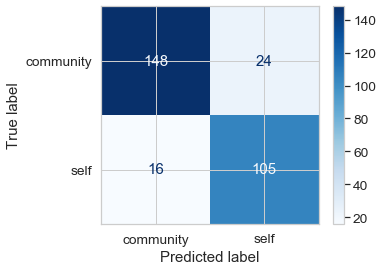

In [85]:
best_index = results.index[0]

# note: for a simple printed matrix, you can use:
# confusion_matrix(y_test, preds[best_index])

plot_confusion_matrix(models[best_index], 
                      X_test, 
                      y_test,
                      cmap = plt.cm.Blues,
                      values_format = 'd')

## Error Analysis

Provide clues on why some instances were wrongly classified and how to improve the model

In [86]:
for input, prediction, label in zip (X_test, pred, y_test):
  if prediction != label:
    print(input, 'has been classified as ', prediction, 'and should be ', label)

have_outofwork has been classified as  self and should be  community
have_mask has been classified as  self and should be  community
have_lunch has been classified as  self and should be  community
Date_WeekOfYear has been classified as  community and should be  self
state_HI has been classified as  community and should be  self
state_MA has been classified as  self and should be  community
state_MD has been classified as  community and should be  self
state_NC has been classified as  community and should be  self
state_NJ has been classified as  community and should be  self
state_SC has been classified as  community and should be  self
state_VA has been classified as  self and should be  community
state_WV has been classified as  community and should be  self
category_Animals & Pets has been classified as  community and should be  self
category_Babies, Kids & Family has been classified as  self and should be  community
category_Business & Entrepreneurs has been classified as  self an